In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import torchvision.transforms as transforms
import torchvision
import numpy as np

In [52]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [55]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available:  True


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
        self.bnm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 64, 3, padding = 1)
        self.bnm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.bnm3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
        self.bnm4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.bnm5 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(256, 256, 3, padding = 1)
        self.bnm6 = nn.BatchNorm2d(256)

        self.conv7 = nn.Conv2d(256, 256, 3, padding = 1)
        self.bnm7 = nn.BatchNorm2d(256)

        self.conv8 = nn.Conv2d(256, 512, 3, padding = 1)
        self.bnm8 = nn.BatchNorm2d(512)

        self.conv9 = nn.Conv2d(512, 512, 3, padding = 1)
        self.bnm9 = nn.BatchNorm2d(512)

        self.conv10 = nn.Conv2d(512, 512, 3, padding = 1)
        self.bnm10 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(2*2*512, 1000)

        self.fc2 = nn.Linear(1000, 500)

        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.bnm1(x)

        x = F.relu(self.conv2(x))
        x = self.bnm2(x)

        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = self.bnm3(x)

        x = F.relu(self.conv4(x))
        x = self.bnm4(x)

        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv5(x))
        x = self.bnm5(x)

        x = F.relu(self.conv6(x))
        x = self.bnm6(x)

        x = F.relu(self.conv7(x))
        x = self.bnm7(x)

        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv8(x))
        x = self.bnm8(x)

        x = F.relu(self.conv9(x))
        x = self.bnm9(x)

        x = F.relu(self.conv10(x))
        x = self.bnm10(x)

        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 2*2*512)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [0]:
net = Net().to(device)

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [89]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #print('Loss: ', running_loss)
        if i % 64000 == 63999:    # print every 2000 mini-batches
            print('[Epoch: %d, Batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Epoch: ', epoch + 1)
    print('Accuracy of the network: {}%'.format(
      100 * correct / total))

print('Finished Training')

Epoch:  1
Accuracy of the network: 86.95%
Epoch:  2
Accuracy of the network: 86.95%


KeyboardInterrupt: ignored

In [0]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [91]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 86.95%


In [92]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 88.4
car        - 93.8
bird       - 79.8
cat        - 74.0
deer       - 85.4
dog        - 80.7
frog       - 91.6
horse      - 90.9
ship       - 92.7
truck      - 92.2


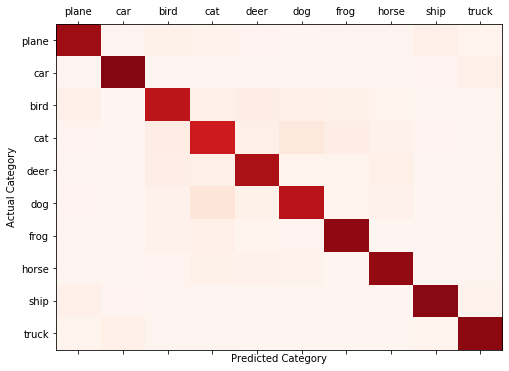

In [93]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Reds'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [94]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           884       6         27        16        9         3         5         5         33        12        
                0.884     0.006     0.027     0.016     0.009     0.003     0.005     0.005     0.033     0.012     
car             7         938       3         3         3         2         4         0         8         32        
                0.007     0.938     0.003     0.003     0.003     0.002     0.004     0.0       0.008     0.032     
bird            33        2         798       39        47        36        27        12        3         3         
                0.033     0.002     0.798     0.039     0.047     0.036     0.027     0.012     0.003     0.003     
cat             10        3         50        740       34        85        46        20        8         4         
                0.01      0.003     0.05      0.74      0.034   

In [95]:
from sklearn.metrics import precision_recall_fscore_support as score

pred = [] 
y_test = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(predicted)):
            pred.append(classes[predicted[i]])
            y_test.append(classes[labels[i]])

precision, recall, fscore, support = score(y_test, pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.81180061 0.93706294 0.75356415 0.84554455 0.82346939 0.88845781
 0.90268123 0.88577154 0.92055611 0.92107892]
recall: [0.798 0.938 0.74  0.854 0.807 0.916 0.909 0.884 0.927 0.922]
fscore: [0.80484115 0.93753123 0.74672048 0.84975124 0.81515152 0.90201871
 0.9058296  0.88488488 0.92376682 0.92153923]
